# This is a document that tries keras on jupyter notebook

## Several notes for 11.17
1. Normalizing input data is essential
2. for categorical result, even though there are only two categories, use multi output and softmax. This is necessary as for calculating output in real cases, there are more variables to compare to, thus higher security of a good result.
3. it is high time to redo the training with __class reweighting__.!!!!

In [55]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
import re
from gensim.models.wrappers.fasttext import FastText as FT_wrapper
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential, Model, load_model
from keras.layers import Bidirectional
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout, AlphaDropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add, subtract
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.initializers import VarianceScaling, RandomUniform
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

In [13]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.suptitle(self.title, fontsize=24)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        try:
            val_acc = logs['val_acc']
        except:
            val_acc = logs['val_mean_squared_error']    
        try:
            acc = logs['acc']
        except:
            acc = logs['mean_squared_error']
        if epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
            if interval == 1:
                self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
                self.ax1.plot(self.index_graph, self.loss_graph, '-r')
                self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
                self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
                self.ax2.plot(self.index_graph, self.acc_graph, '-r')
                self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
                self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
                self.fig.canvas.draw()
                time.sleep(0.05)
        elif epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 2
VisualizeCallback.title = "plot"

In [40]:
def is_desired_letter(char):
    return ord(char) >= 97 and ord(char) < 123 or ord(char) >= 48 and ord(char) < 58 or ord(char) == ord(" ")


# return even number of 0 and 1 if is_even_result is True
def get_train_data(train_portion, wv_model, is_even_test_data=True, is_neg_1_as_0=False, is_second_round_data=False, normalize_portion=0.45):
    np.random.seed(7)
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("../input/kickstarter_train.csv")
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    # do preliminary preprocessing:remove all symbols and split to words lists
    train_data["desc"] = [[char for char in str(text).lower() if is_desired_letter(char)] for
                          text in train_data["desc"]]
    train_data["desc"] = [''.join(text).split() for text in train_data["desc"]]
    # remove words that cannot be expressed
    train_data["desc"] = [[word for word in text if word in wv_model] for text in train_data["desc"]]
    # word 2 vector
    train_data["desc"] = [np.array(list(map(wv_model.word_vec, text))) for text in train_data["desc"]]
    # remove too short desc
    drop_index = []
    for i in range(len(train_data)):
        if train_data.iloc[i, 2].shape[0] <= 2:
            drop_index.append(i)
    train_data = train_data.drop(train_data.index[drop_index])
    
    # tokenize all countries
    # load dictionary or genrate one online
    try:
        country_dict = Dictionary.load("../num_model/num_data/country_dict.pkl")
        print("loading country dictionary successful from disk")
    except:
        print("No country dictionary available, generating from data")
        country_dict = Dictionary([train_data.iloc[:, 6]])
        country_dict.save("../num_model/num_data/country_dict.pkl")
        print("new dictionary saved to num_data")
    # start tokenization
    try:
        train_data.iloc[:, 6] = np.array(list(map(country_dict.token2id.get, train_data.iloc[:, 6]))) # map gives extra speed~
    except:
        print("Warning!!! A country does not exist in current dictionary!!!")
    
    # count zeros and ones and get weights for each sample
    counter = train_data.iloc[:, -1].value_counts().to_dict()
    zeros = float(counter[0])
    ones = float(counter[1])
    max_result = max(zeros, ones)
    weights = [ones / max_result, zeros / max_result]
    
    # get goal normalization para
    normalize_split_point = int(normalize_portion * len(train_data))
    temp_train_goals = np.array(train_data.iloc[:normalize_split_point, 3])
    goal_mean = temp_train_goals.mean()
    goal_std = temp_train_goals.std()
    
    # get backer normalization para
    temp_train_backers = np.array(train_data.iloc[:normalize_split_point, -2])
    backer_mean = temp_train_backers.mean()
    backer_std = temp_train_backers.std()
    
    # seperate train and test data
    if is_second_round_data == False:
        split_point = int(train_portion * len(train_data))
        test_data = train_data.iloc[split_point:, :]
        train_data = train_data.iloc[:split_point, :]
    else:
        split_point = int(train_portion * len(train_data))
        split_point_2 = int(train_portion * len(train_data) * 2)
        test_data = train_data.iloc[split_point_2:, :]
        train_data = train_data.iloc[split_point:split_point_2, :]
        
    # even test data
    # for test data count 0 and drop some until sample of 1 = sample of 0
    if is_even_test_data:
        print("even test data")
        status_count = test_data.iloc[:, -1].value_counts().to_dict()
        drop_zero_num = status_count[0] - status_count[1]
        drop_zero_p = drop_zero_num / float(status_count[0])
        drop_index = []
        for i in range(len(test_data)):
            if test_data.iloc[i, -1] == 0:
                if np.random.uniform(low=0, high=1) < drop_zero_p:
                    drop_index.append(i)
        test_data = test_data.drop(test_data.index[drop_index])
        status_count = test_data.iloc[:, -1].value_counts().to_dict()
        print(float(status_count[0]) / float(status_count[1]))
        # shuffle the whole data
        test_data = test_data.sample(frac=1).reset_index(drop=True)
    else:
        print("do not even test data")

    # get descriptions data
    train_texts = np.array(train_data.iloc[:, 2])
    test_texts = np.array(test_data.iloc[:, 2])
    # get goal data
    train_goals = (np.array(train_data.iloc[:, 3]) - goal_mean) / goal_std
    test_goals = (np.array(test_data.iloc[:, 3]) - goal_mean) / goal_std
    # get backer data
    # train_backers = (np.array(train_data.iloc[:, -2]) - backer_mean) / backer_std
    # test_backers = (np.array(test_data.iloc[:, -2]) - backer_mean) / backer_std
    train_backers = np.array(train_data.iloc[:, -2])
    test_backers = np.array(test_data.iloc[:, -2])
    # get country data
    train_countries = np.array(train_data.iloc[:, 6])
    test_countries = np.array(train_data.iloc[:, 6])
    # get result data
    train_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[:, -1]])
    train_results_single = np.array(train_data.iloc[:, -1])
    train_weights = np.array([weights[i] for i in train_data.iloc[:, -1]])
    test_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in test_data.iloc[:, -1]])
    test_results_single = np.array(test_data.iloc[:, -1])
    # test_weights = np.array([weights[i] for i in test_data.iloc[:, -1]])
    # convert 1, 0 results to 1, -1
    if is_neg_1_as_0:
        train_results_single = np.array([1 if item == 1 else -1 for item in train_results_single])
        test_results_single = np.array([1 if item == 1 else -1 for item in test_results_single])
        train_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in train_results_double])
        test_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in test_results_double])

    
    return {"texts": train_texts, "countries": train_countries, "goals": train_goals, "backers": train_backers,
            "results_double": train_results_double, "results_single": train_results_single, 
            "result_class_weight": train_weights}, \
           {"texts": test_texts, "countries": test_countries, "goals": test_goals, "backers": test_backers,
            "results_double": test_results_double, "results_single": test_results_single}, 

In [41]:
# get training testing data from disk
train_portion = 0.45
train_data, test_data = get_train_data(train_portion, wv_model=wv_model, is_even_test_data=False)
print("data grabbed")

loading country dictionary successful from disk
1.0001060670343658
data grabbed


In [42]:
# truncate and pad input sequences
max_desc_length = 35
train_data["texts"] = pad_vector_sequence(train_data["texts"], max_len=max_desc_length)
test_data["texts"] = pad_vector_sequence(test_data["texts"], max_len=max_desc_length)
print("padding finished")

padding finished


# Now use LSTM with forking (and residue to lstm output)
__seemingly using forked_sigmoid classifier is easier to converge than forked_softmax classifier__

__using SVM leads to a faster convergence rate yet similar (~0.61) test accuracy__

__using selu (of course with alpha dropout and custom weight initialization) leads to a faster convergence rate of test accuracy, and after some fine-tuning (with batch size 256), the test accuracy has reached it's historical best:0.638__

In [19]:
def MultiLayerLSTMCell(sequence_input, dropout_level=0.2, layer_num=1, layer_width=32):
    this_input = sequence_input
    for i in range(layer_num):
        if i == layer_num - 1:
            is_return_sequence = False
        else:
            is_return_sequence = True
        x = LSTM(units=layer_width, dropout=dropout_level, name="Recurrent_" + str(i), 
                 return_sequences=is_return_sequence)(this_input)
        this_input = BatchNormalization()(x)
    return this_input

def DenseNetCell(dense_in, dropout_level=0.25, res_num=1, activation_name="tanh", l2_para=0.001):
    this_input = dense_in
    for i in range(res_num):
        if activation_name != 'selu':
            x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(l2_para))(this_input)
            x = BatchNormalization()(x)
            x = Activation(activation_name)(x) 
            x = Dropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = BatchNormalization()(res_out)
            x = Dropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
        else:
            x = Dense(int(this_input.shape[1]), kernel_initializer=
                        VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
                        activity_regularizer=l2(l2_para))(this_input)
            x = Activation(activation_name)(x)
            x = AlphaDropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = AlphaDropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
    dense_out = Dense(1)(this_input)
    return dense_out


# generate model for descriptions + country
desc_rnn_input = Input(shape=(35, word_vector_len))
x = MultiLayerLSTMCell(desc_rnn_input, dropout_level=0.2, layer_num=1, layer_width=64)
x = BatchNormalization()(x)
fork_in = Dropout(0.2)(x)
# fork network for isolately decide is 1 or is 0
x = concatenate(inputs=[DenseNetCell(fork_in, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001), 
                               DenseNetCell(fork_in, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001)])
x = Activation("selu")(x)
x = Activation("softmax")(x)
desc_rnn_model = Model(inputs=[desc_rnn_input], outputs=[x])

print("model building finished\n", desc_rnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35, 300)      0                                            
__________________________________________________________________________________________________
Recurrent_0 (LSTM)              (None, 64)           93440       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64)           256         Recurrent_0[0][0]                
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 64)           256         batch_normalization_5[0][0]      
__________________________________________________________________________________________________
dropout_4 

<IPython.core.display.Javascript object>


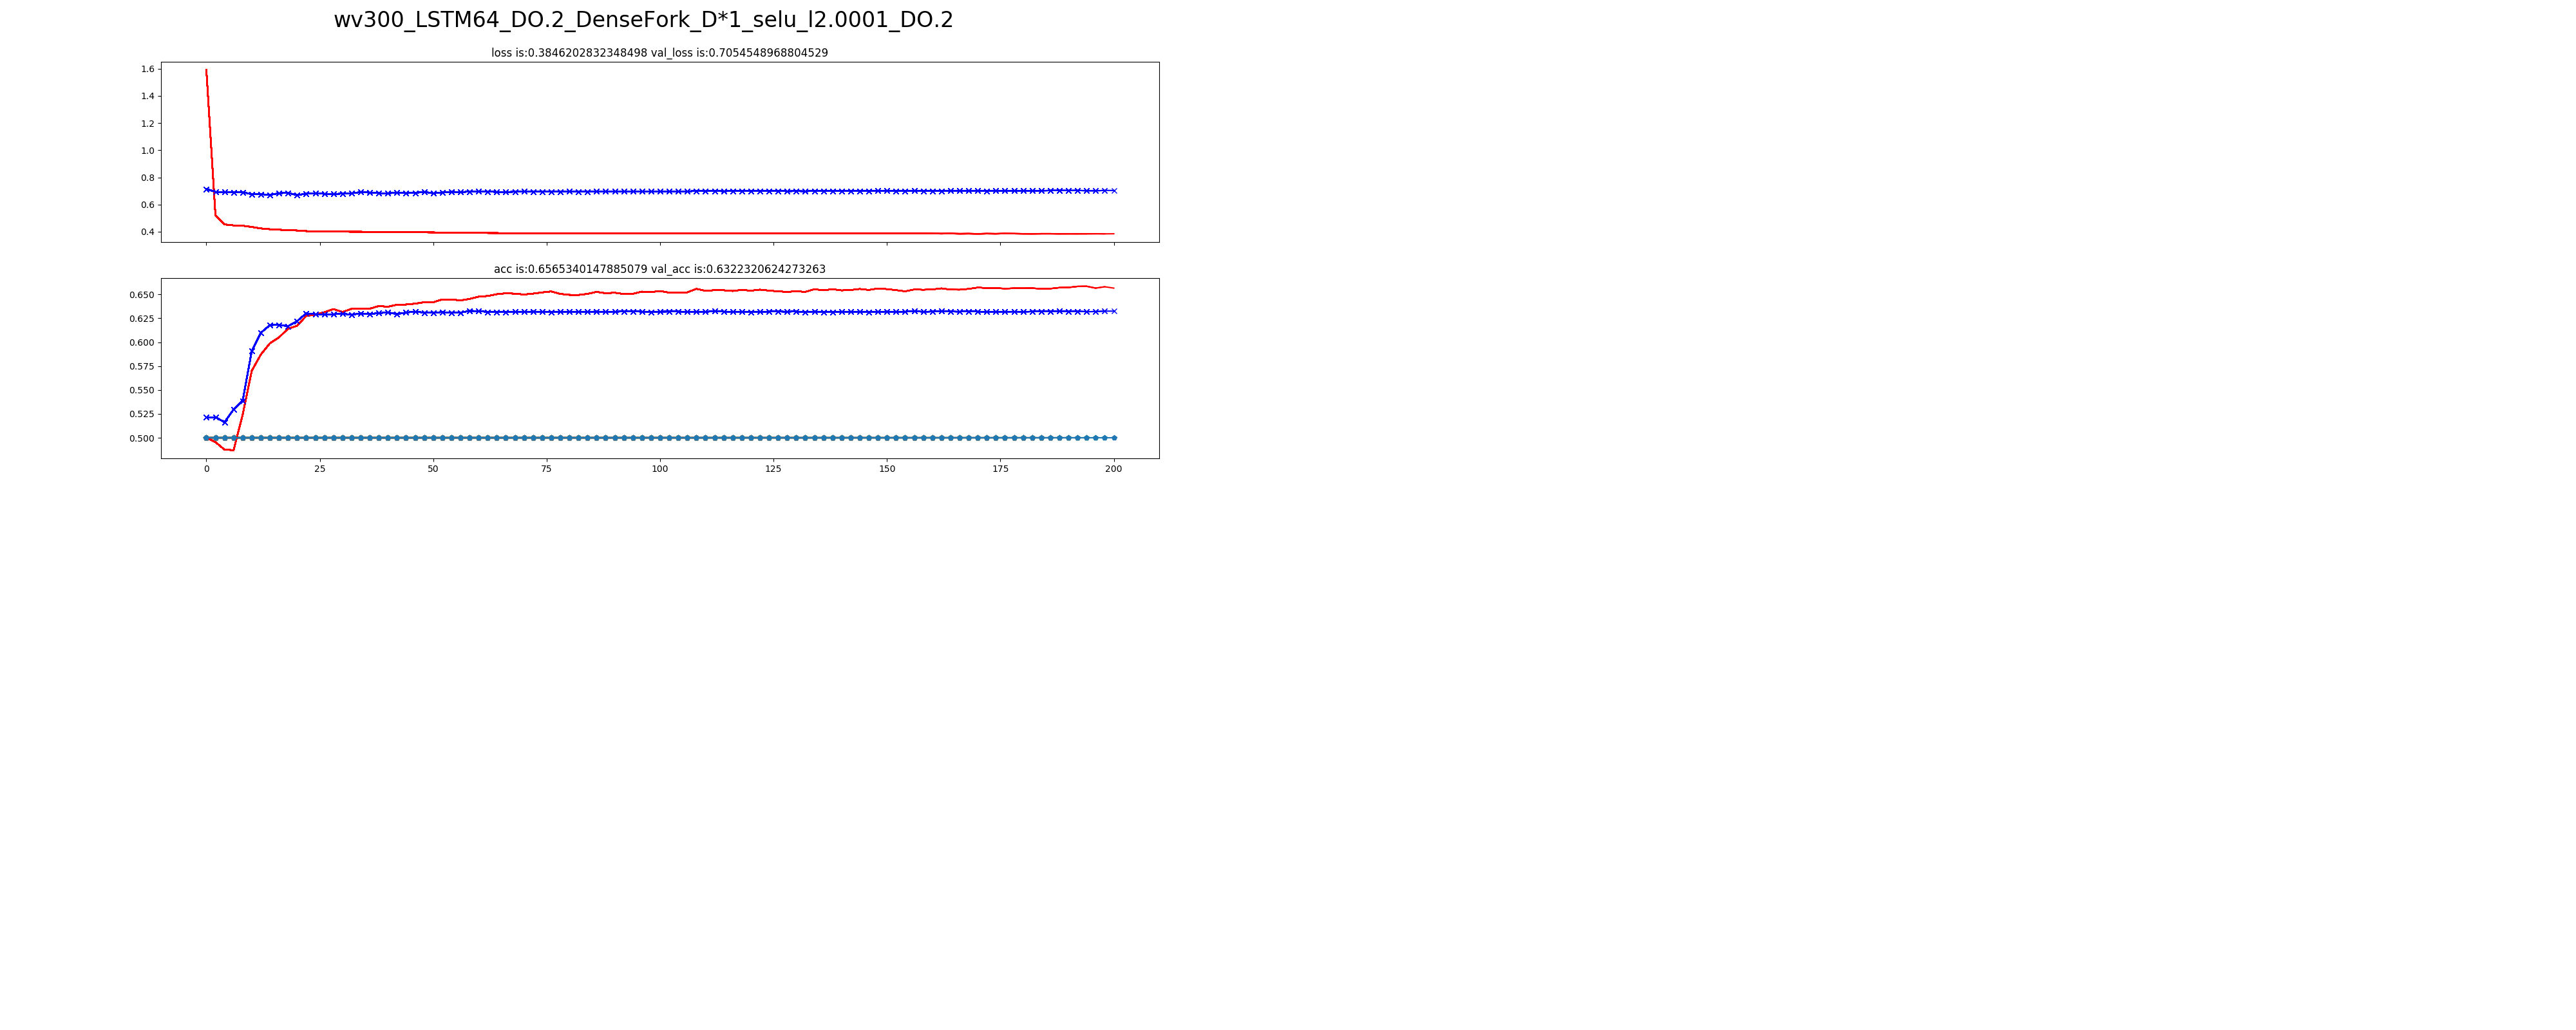

KeyboardInterrupt: 

In [24]:
# configurate model training
desc_rnn_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# do training
VisualizeCallback.interval = 2
VisualizeCallback.title = "wv300_LSTM64_DO.2_DenseFork_D*1_selu_l2.0001_DO.2"
desc_rnn_model.fit(train_data['texts'], train_data['results_double'], epochs=1000, batch_size=256, shuffle=True,
                  verbose=0, validation_data=[test_data["texts"], test_data['results_double']], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.00001, cooldown=30), VisualizeCallback],
                   sample_weight=train_data['result_class_weight'])

desc_rnn_model.save("desc_data/desc_rnn_model_" + VisualizeCallback.title + ".hdf5")

In [25]:
scores = desc_rnn_model.evaluate(x=[test_data['texts']], y=[test_data['results_double']])
print(scores)
desc_rnn_model.save("desc_data/desc_rnn_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

37714/37714 [==============================] - 8s 206us/step
[0.70384151002992446, 0.63241766982134939]


# investigating the statistics of prediction
* for random guesses, correct prediction rate for 1 should equal to the frequency of 1 in data set, vice versa

In [113]:
zeros = 0.0
ones = 0.0
for i in test_data['results_double']:
    if i[0] == 0:
        zeros += 1
    else:
        ones += 1
print("frequency of zero is: ", zeros/(ones+zeros))

# get predictions
desc_model = desc_rnn_vanilla_model
try:
    result = [1 if item[0] > item[1] else 0 for item in desc_model.predict_on_batch(test_data['texts'])]
    # get predicted statistics
    pred_zeros = float(len([1 for item in result if item == 0]))
    pred_ones = float(len(result) - pred_zeros)
    print("predicted frequency of zero is: ", pred_zeros/len(result))

    # get right statistics
    right_ones = float(len([1 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 1]))
    right_zeros = float(len([0 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 0]))
    print("correct rate for 1 predictions: ",   right_ones / pred_ones)
    print("proportion of correct 1 predictions: ", right_ones / ones)
    print("correct rate for 0 predictions: ",   right_zeros / pred_zeros)
    print("proportion of correct 0 predictions: ", right_zeros / zeros)

    print("overall accuracy is: ", (right_zeros + right_ones) / len(result))
except:
    result = [1 if item > 0.5 else 0 for item in desc_model.predict_on_batch([test_data['texts'], test_data['goals']])]
    # get predicted statistics
    pred_zeros = float(len([1 for item in result if item == 0]))
    pred_ones = float(len(result) - pred_zeros)
    print("predicted frequency of zero is: ", pred_zeros/len(result))

    # get right statistics
    right_ones = float(len([1 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 1]))
    right_zeros = float(len([0 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 0]))
    print("correct rate for 1 predictions: ",   right_ones / pred_ones)
    print("proportion of correct 1 predictions: ", right_ones / ones)
    print("correct rate for 0 predictions: ",   right_zeros / pred_zeros)
    print("proportion of correct 0 predictions: ", right_zeros / zeros)

    print("overall accuracy is: ", (right_zeros + right_ones) / len(result))

frequency of zero is:  0.5000265153523891
predicted frequency of zero is:  0.5611178872567216
correct rate for 1 predictions:  0.639258095698405
proportion of correct 1 predictions:  0.561147645311837
correct rate for 0 predictions:  0.6089689065305737
proportion of correct 0 predictions:  0.6833704528582034
overall accuracy is:  0.6222622898658323


In [19]:
func = K.function(inputs=[desc_model.input, K.learning_phase()], outputs=[desc_model.layers[-2].output])
second_last_layer_output = func([test_data['texts'], 0])

In [20]:
[item for item in second_last_layer_output[0]]

[array([ 1.17666662,  1.91166806], dtype=float32),
 array([-0.33087325,  0.61778414], dtype=float32),
 array([-1.06526256, -0.8415361 ], dtype=float32),
 array([-1.07294571, -1.6218971 ], dtype=float32),
 array([ 0.09263682,  0.0226647 ], dtype=float32),
 array([ 0.11063059, -1.08550906], dtype=float32),
 array([ 0.69241846,  2.10820842], dtype=float32),
 array([-0.68021482,  0.1506452 ], dtype=float32),
 array([-1.09966195,  0.3515954 ], dtype=float32),
 array([-0.96627849, -1.55823994], dtype=float32),
 array([ 0.7631017 ,  0.62607723], dtype=float32),
 array([-1.45100439, -1.16533792], dtype=float32),
 array([-0.48573354, -0.02216338], dtype=float32),
 array([-1.31567502, -1.21677089], dtype=float32),
 array([-0.94593751, -0.30448586], dtype=float32),
 array([ 1.67814779,  0.07919337], dtype=float32),
 array([ 0.07376346,  0.19657829], dtype=float32),
 array([-0.41954654, -0.02781548], dtype=float32),
 array([ 0.80225134,  1.17598164], dtype=float32),
 array([-1.24695337, -1.0315851

In [30]:
probability_output = [list(item) for item in desc_model.predict_on_batch(test_data['texts'])]
list(zip(probability_output, test_data['results_double']))

[([0.24938218, 0.7506178], array([0, 1])),
 ([0.30294791, 0.69705212], array([0, 1])),
 ([0.52424896, 0.47575104], array([0, 1])),
 ([0.68811399, 0.31188598], array([1, 0])),
 ([0.59332556, 0.40667439], array([0, 1])),
 ([0.72010189, 0.27989808], array([1, 0])),
 ([0.10520472, 0.89479524], array([0, 1])),
 ([0.51162875, 0.48837122], array([0, 1])),
 ([0.29102322, 0.70897681], array([1, 0])),
 ([0.60400593, 0.39599404], array([0, 1])),
 ([0.69813949, 0.30186054], array([0, 1])),
 ([0.45293349, 0.54706651], array([0, 1])),
 ([0.45922989, 0.54077011], array([1, 0])),
 ([0.61776698, 0.38223302], array([0, 1])),
 ([0.59643346, 0.40356648], array([0, 1])),
 ([0.82911164, 0.17088839], array([1, 0])),
 ([0.61210048, 0.38789949], array([1, 0])),
 ([0.58999467, 0.41000533], array([1, 0])),
 ([0.56367797, 0.43632206], array([0, 1])),
 ([0.54419845, 0.45580155], array([1, 0])),
 ([0.57712507, 0.4228749], array([1, 0])),
 ([0.23460397, 0.765396], array([0, 1])),
 ([0.60835403, 0.39164594], array([1